# Voorspellen van de benodigde IC-capaciteit over een jaar
---
* Uitleggen wat verwacht kan worden

## (S)ARIMA
* Uitleggen wat (S)ARIMA is:
 * Het verschil tussen Arima en SARIMA
 * Wat de parameters betekenen
 
ARIMA en SARIMA zijn twee veel gebruikte modellen die worden gebruikt voor forecasting. Binnen deze paragrafen worden beide modellen toegelicht.

### ARIMA
ARIMA staat voor Auto Regressive Integrated Moving Average. Het ARIMA-model maakt een voorspelling op basis van gegevens die het model toegekend krijgt. Een aspect waar een ARIMA-model niet mee kan werken zijn seizoenen. Een ARIMA-model wordt gekenmerkt door de volgende parameters:
* **p**: Geeft de AR-term aan.
* **d**: Geeft het aantal verschillen aan om de data stationair te maken.
* **q**: Geeft de MA-term aan.

#### AR
AR staat zoals eerder aangegeven voor Auto Regressive. Dit geeft aan dat het model de afhankelijke relatie tussen de huidige gegevens en die uit het verleden gebruikt. Met andere woorden, de voorspellingen zijn gebaseerd op waardes uit het verleden.

#### MA
AM staat voor Moving Average. De Moving Average geeft aan dat de voorspelling van het model, de forecast, afhangt van de waardes uit het verleden. Het betekent echter ook dat de fouten in prognoses lineaire functies zijn van fouten uit het verleden. De Moving Average verwijst naar het aantal vertraagde prognosefouten dat in het ARIMA-model moet worden opgenomen.

#### I
Het aantal keer dat differencing op de datasets toegepast moet worden, alvorens de data stationair is. Dit maakt het voor het ARIMA-model eenvoudiger om voorspellingen te doen. Een voorbeeld van differencing is het verschil tussen twee dagen.

### SARIMA
SARIMA staat voor Seasonal Auto Regressive Integrated Moving Average. In tegenstelling tot het ARIMA-model kan SARIMA _wel_ rekening houden met seizoenen. 

In [122]:
# Importeren van de benodigde libraries

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns # Kan mogelijk weg.
from os import path, getcwd
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pmd
import statsmodels.api as sm

# Negeren van filterwarnings
warnings.filterwarnings("ignore")

## Inladen van de benodigde datasets
---
Binnen de volgende cel worden de volgende datasets ingelezen:
- data_per_dag.csv
- data_per_leeftijd.csv
- Het tabblad NICE van Kopie van AlleCijfers-Corona-besmet-opgenomen-overleden.xlsx.

Daarnaast wordt het tijdbestek van het bestand data_per_dag aangepast, zodat het enkel de data bevat tot 1 november 2021.

In [123]:
# Dataset path
root_dir = path.join(getcwd(), 'Datasets')
alle_cijfers = path.join(root_dir, "Kopie van AlleCijfers-Corona-besmet-opgenomen-overleden.xlsx")

# Inlezen benodigde CSV-bestanden
df_per_dag = pd.read_csv(path.join(root_dir, "data_per_dag.csv"))
df_per_leeftijd = pd.read_csv(path.join(root_dir, "data_per_leeftijd.csv"))
df_per_dag_recent = pd.read_excel(alle_cijfers, sheet_name="NICE")

# Eerste week van df_per_dag halen, zodat de tijdranges in beide datasets overeen komen.
df_per_dag["Date_adj"] = pd.to_datetime(df_per_dag["Date_adj"])
df_per_dag = df_per_dag.loc[(df_per_dag["Date_adj"] >= "2020-04-01") & (df_per_dag["Date_adj"] < "2021-11-01")]

df_per_dag_recent.head(5)

,Datum,Aanwezig op IC verdacht of bewezen Corona,Aanwezig op verpleegafdeling verdacht of bewezen Corona,Opname IC Corona,Opname IC verdacht,Opname IC totaal,Opname verpleegafdeling Corona,Opname verpleegafdeling verdacht,Opname verpleegafdeling totaal,Overleden,Levend het ziekenhuis verlaten,Levend de IC verlaten,Cumulatief op IC (geweest) verdacht of bewezen Corona,Cumulatief op verpleegafdeling (geweest) verdacht of bewezen Corona
0,2022-01-16,333,959,4,0,4,10,1,11,4628,11363,278,16914,78040
1,2022-01-15,340,997,10,0,10,33,11,44,4628,11363,278,16910,78032
2,2022-01-14,359,1039,9,0,9,63,13,76,4625,11357,275,16900,77996
3,2022-01-13,377,1096,14,0,14,72,9,81,4618,11341,270,16891,77930
4,2022-01-12,392,1144,11,0,11,85,6,91,4607,11318,276,16877,77863


In [124]:
# Set index dataset
df_per_dag["Date_adj"] = pd.to_datetime(df_per_dag["Date_adj"])
Index_df_per_dag = df_per_dag[["Aanwezig op IC verdacht of bewezen Corona", "Date_adj"]]
Index_df_per_dag.set_index(["Date_adj"], inplace=True)

Index_df_per_dag.head()

,Aanwezig op IC verdacht of bewezen Corona
Date_adj,
2021-10-31,231
2021-10-30,222
2021-10-29,234
2021-10-28,220
2021-10-27,216


In [125]:
# Replace daily numbers with montly averages and set Date_adj to index
Index_df_per_dag_log = np.log(Index_df_per_dag["Aanwezig op IC verdacht of bewezen Corona"]).resample("W").max()
Index_df_per_dag = Index_df_per_dag["Aanwezig op IC verdacht of bewezen Corona"].resample("W").max()

Index_df_per_dag.head()

Date_adj
2020-04-05    1312
2020-04-12    1321
2020-04-19    1228
2020-04-26    1020
2020-05-03     787
Freq: W-SUN, Name: Aanwezig op IC verdacht of bewezen Corona, dtype: int64

## Verdelen van de dataset in een train- en testset.
---
Het dataframe Index_df_per_dag wordt in tweën gesplitst in een train en dataset. Deze sets gaan gebruikt worden voor het trainen en valideren van het model.

In [126]:
train = Index_df_per_dag[:63]
test = Index_df_per_dag[63:]

# Opstellen van het ARIMA-model
---
1. p-value bepalen met behulp van de Augmented Dickey Fuller test.
2. Predict p, q and d
3. Build model
4. Visualize model
5. Evaluate model

Gebruikmakend van de adfuller test wordt de waarde van de d-parameter bepaald. Deze parameters geeft aan hoevaak de dataset gedifferenced moet worden, alvorens deze stationair is, [zoals te zien is in de deze bron](https://stats.stackexchange.com/questions/394796/should-my-time-series-be-stationary-to-use-arima-model). Aangezien de Covid-19 data verre van stationair is dient de waarde van d minimaal 1 te zien.

p-value: 0.000261


<AxesSubplot:xlabel='Date_adj'>

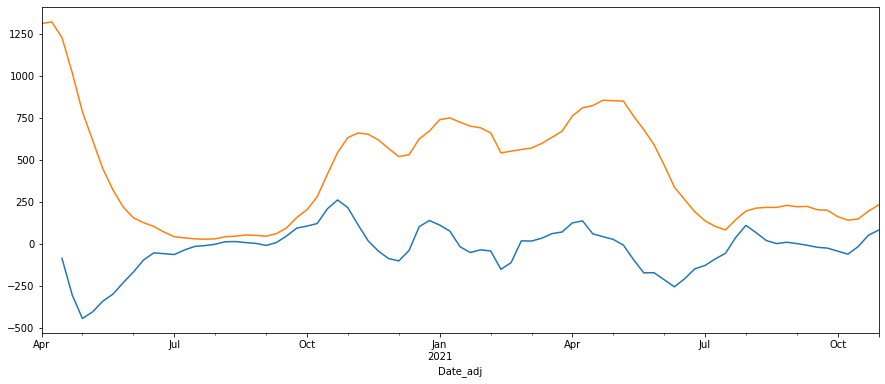

In [127]:
# Get P-value
diff_1 = Index_df_per_dag.diff(2).dropna()
result = adfuller(diff_1)
print("p-value: %f" % result[1])

diff_1.plot(figsize=(15,6))
Index_df_per_dag.plot()

Uit de resultaten van bovenstaande cel blijkt de p-value, die de stationary van de data weergeeft, pas na een diff toe te passen op een waarde onder de 0,05 uit te komen. Hieruit kan geconcludeerd worden dat de d binnen het Arima-model de waarde **2** zou moeten krijgen.

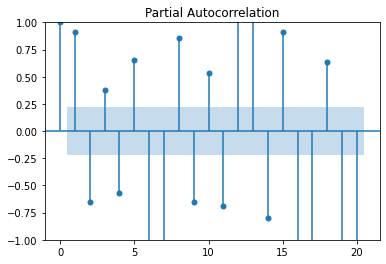

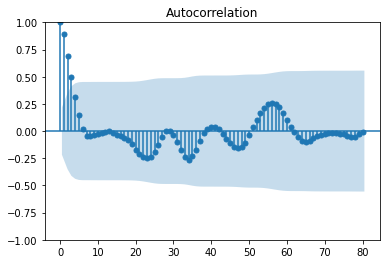

In [128]:
# Find the p, AR-term 
plot_pacf(diff_1)

# Find the q, MA-term
plot_acf(diff_1, lags=len(Index_df_per_dag)-3) # -3 because of the diffence of 1.

plt.show()

Uit de partial autocorrelation blijken alle waardes uit het blauwe gebied te komen, en geeft aan dat enige vorm van autocorrelatie binnen de series te verwijderen is. In de volgende cel wordt de argumented fuller test nogmaals uitgevoerd op gelogde waardes van de data. 

p-value: 0.016083


<AxesSubplot:xlabel='Date_adj'>

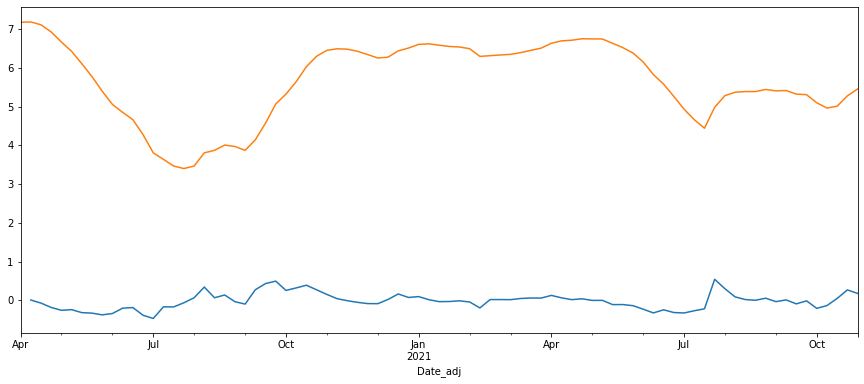

In [129]:
# Get P-value
diff_2 = Index_df_per_dag_log.diff(1).dropna()
result = adfuller(diff_2)
print("p-value: %f" % result[1])

diff_2.plot(figsize=(15,6))
Index_df_per_dag_log.plot()

Uit de resultaten van bovenstaande cel blijkt de p-value, die de stationary van de data weergeeft, pas na een diff toe te passen op een waarde onder de 0,05 uit te komen. Hieruit kan geconcludeerd worden dat de d binnen het Arima-model de waarde **1** zou moeten krijgen. Binnen de volgende cellen wordt gezocht naar de q en p

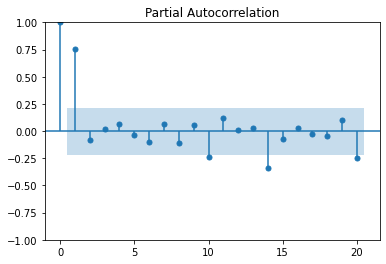

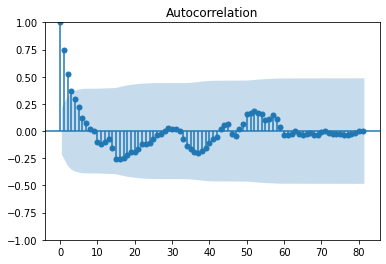

In [130]:
# Find the p, AR-term 
plot_pacf(diff_2)

# Find the q, MA-term
plot_acf(diff_2, lags=len(Index_df_per_dag)-2) # -2 because of the diffence of 1.

plt.show()

De partial autocorrelation bevat nu punten die binnen het blauwe gebied vallen. Naar aanleiding van de partial correlation en autocorrelation dienen p en q de volgende waardes te krijgen:
- p: 1
- q: 2

### Gevonden parameters
----
Naar aanleiding van de bovenstaande grafieken zou de order van ARIMA er als volgt uit moeten zien:
* p &#8594; 1
* d &#8594; 1
* q &#8594; 2
  
Ter validatie wordt in de volgende cel de waardes van p, d en q voorspeld gebruikmakend van pmdarima. Het packet pmdarima maakt het mogelijk de ARIMA-parameters (p,d,q) te bepalen aan de hand van een aantal parameters. In de volgende cel worden aan de hand van de module "auto_arima" de meest passende parameters bepaald. Deze worden net zoals de met de hand uitgerekende parameters later binnen dit notebook getraind. Het ARIMA-model met de laagste Root Mean Squared Error wordt gebruikt voor het voorspellen van de benodigde IC-capaciteit.

In [131]:
def arimamodel(timeseriesarray):

    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              start_p=0, 
                              start_q=0,
                              test="adf",
                              d=None,
                              m=52,
                              approximation=True,
                              Seasonal=True,
                              trace=False)

    return autoarima_model

arimamodel(Index_df_per_dag)

ARIMA(order=(2, 1, 1), scoring_args={}, seasonal_order=(1, 0, 0, 52),
      suppress_warnings=True, with_intercept=False)

Uit de auto_arima-functie komen de volgende parameters:
* p &#8594; 2
* d &#8594; 1
* q &#8594; 1

Naast de standaard ARIMA-order is een optimale seasonal_order gegeven. De optimale seasonal order ziet er als volgt uit:
* P &#8594; 1
* D &#8594; 0
* Q &#8594; 0
* Periode &#8594; 52

De periode heeft de waarde 52 gekregen. Dit getal geeft het aantal stappen weer die nodig zijn om een seasonal period, in dit geval een jaar, te doorlopen. 

In de volgende cel worden twee ARIMA-modellen met beide orders getraind. Van ieder model wordt de Root Mean Squared Error (RMSE) berekend. De order met de laagste RMSE wordt gebruikt om het ARIMA-model te trainen.

In [132]:
orders = np.array([[2,1,1], [1,1,2], [3,1,4], [2,1,3]])
rmse = []

for i in orders:
    model = ARIMA(train, order=(i)).fit()
    pred = model.predict(start=len(train), end=(len(Index_df_per_dag) -1))
    rmse_value = np.mean((pred - test.values)**2)**.5
    print("Order", i, "RMSE", rmse_value)
    rmse.append(rmse_value)
    rmse_value

min_rmse = min(rmse)
index_rmse = rmse.index(min_rmse)
best_order = orders[index_rmse]

print("De ARIMA-order met de laagste Root Mean Squared Error is: ",best_order , "met een waarde van: ", min_rmse,"."\
    " Vanaf dit punt wordt bij het trainen van de verschillende modellen de volgende order aangehouden: ", best_order)

Order [2 1 1] RMSE 99.75633825589728
Order [1 1 2] RMSE 263.9533165513294
Order [3 1 4] RMSE 22.938530655323476
Order [2 1 3] RMSE 22.162675776389694
De ARIMA-order met de laagste Root Mean Squared Error is:  [2 1 3] met een waarde van:  22.162675776389694 . Vanaf dit punt wordt bij het trainen van de verschillende modellen de volgende order aangehouden:  [2 1 3]


Text(0, 0.5, 'Benodigde IC-capaciteit per maand.')

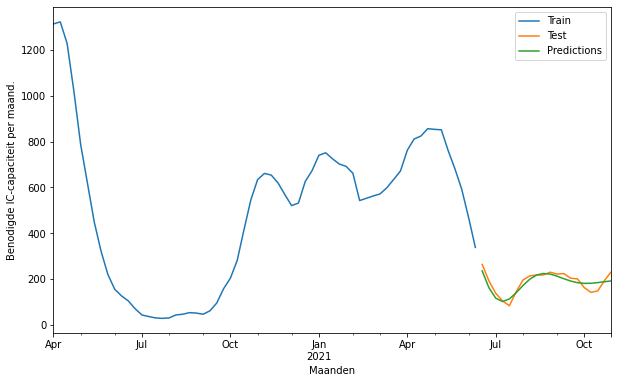

In [133]:
# Build model with the best parameters
model = ARIMA(train, order=(2,1,3)).fit()
pred = model.predict(start=len(train), end=(len(Index_df_per_dag) -1))

#Plot results 
train.plot(legend=True, label="Train", figsize=(10,6))
test.plot(legend=True, label="Test")
pred.plot(legend=True, label="Predictions")
plt.xlabel("Maanden")
plt.ylabel("Benodigde IC-capaciteit per maand.")

In [143]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           SARIMAX Results                                           
=====================================================================================================
Dep. Variable:     Aanwezig op IC verdacht of bewezen Corona   No. Observations:                   63
Model:                                        ARIMA(2, 1, 3)   Log Likelihood                -314.433
Date:                                       Sat, 22 Jan 2022   AIC                            640.865
Time:                                               14:26:38   BIC                            653.628
Sample:                                           04-05-2020   HQIC                           645.876
                                                - 06-13-2021                                         
Covariance Type:                                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4765      0.262      5.628      0.000       0.962       1.991
ar.L2         -0.7150      0.223     -3.200      0.001      -1.153      -0.277
ma.L1         -0.5176      0.334     -1.549      0.121      -1.173       0.137
ma.L2          0.1812      0.168      1.080      0.280      -0.148       0.510
ma.L3          0.3037      0.219      1.387      0.165      -0.125       0.733
sigma2      1439.7266    260.124      5.535      0.000     929.893    1949.560
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.41
Prob(Q):                              0.97   Prob(JB):                         0.18
Heteroskedasticity (H):               1.59   Skew:                            -0.26
Prob(H) (two-sided):                  0.29   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Uit de grafiek blijkt dat de predictiewaarden nagenoeg overeen komen met de testwaardes. Hieruit lijkt vooralsnog het model adequaat te zijn. In de volgende cel wordt een predictie met behulp van ARIMA gemaakt die de IC-capaciteit per week tot en met 1 november 2022 voorspeld.

# Validate model with 2020 data
---
Binnen deze sectie wordt nogmaals een ARIMA-model gemaakt. Dit model heeft als doel de predicties die het model doet over 2021 te valideren.

In [134]:
# Create Train and Test set
train_2020 = Index_df_per_dag[:39]
test_2021 = Index_df_per_dag[39:]

In [135]:
model_2020 = ARIMA(train_2020, order=(2,1,1)).fit()

pred_2020 = model_2020.predict(start=len(train_2020), end=(len(Index_df_per_dag) -1))

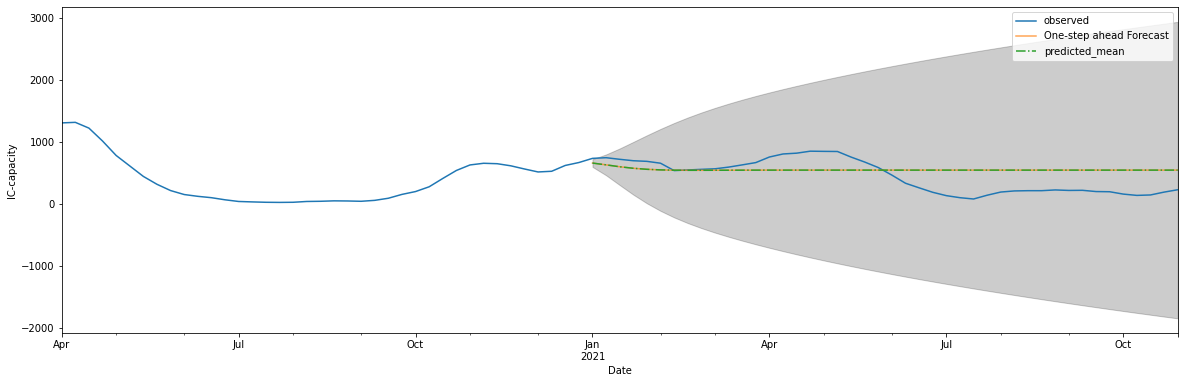

In [136]:
# Visualize predictions v.s. test values
pred = model_2020.get_prediction(start=pd.to_datetime('2021-01-03'), end=(len(Index_df_per_dag)-1), dynamic=False)
pred_ci = pred.conf_int()

# Plotting IC-capacity
ax = Index_df_per_dag['2020':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(20,6))
pred_2020.plot(ls="-.")
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('IC-capacity')
plt.legend()

plt.show()

Naast de testdata kan het model ook de bekende data van een jaar voorspellen. Hieruit kan geconcludeerd worden dat het model valide is. In de volgende cel wordt het ARIMA-model getraind.

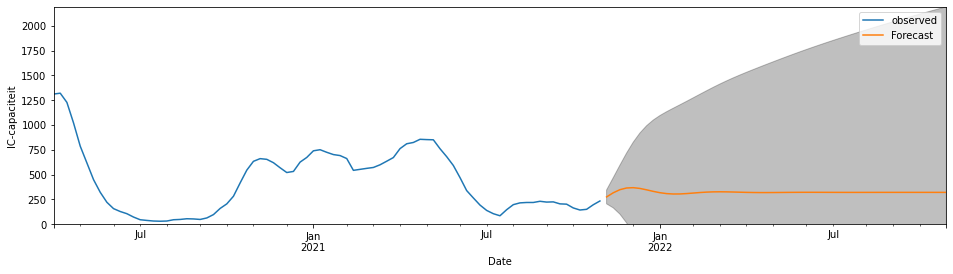

In [137]:
# Predict the future data.
final_model = ARIMA(Index_df_per_dag, order=(2,1,3)).fit()

prediction = final_model.predict(len(Index_df_per_dag), len(Index_df_per_dag) + 365)

# Dezelfde plot als bovenstaande cel, met onzekerheid.
# Get forecast 12 steps ahead in future
pred_uc = final_model.get_forecast(steps=52)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

# Plot the model
ax = Index_df_per_dag.plot(label='observed', figsize=(16,4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('IC-capaciteit')
ax.set_ylim(0,pred_ci.iloc[:, 1].max())

plt.legend()
plt.show()

De predicties die vanuit het ARIMA-model naar voren zijn gekomen zijn te vinden in bovenstaande grafiek. Binnen de grafiek is te zien dat de oranje lijn (de voorspellingen, na februari 2022 afvlakken. Daarnaast is te zien dat het onzekere gebied, het grijze vlak, steeds onzekerder wordt. Naar aanleiding [van het forum stats.stackexchange](https://stats.stackexchange.com/questions/286900/arima-forecast-straight-line) lijkt de stagnering te komen doordat ARIMA geen rekening kan houden en daardoor seizoenen niet herkend. Een model dat hier wel rekening mee houdt is SARIMA. In het volgende hoofdstuk worden twee SARIMA-modellen getraind met de eerder genoemde orders, namelijk:
1. 2,1,1
2. 1,1,2

## Residual errors
---
Binnen deze paragraaf worden de Residual Errors van het ARIMA-model weergegeven.

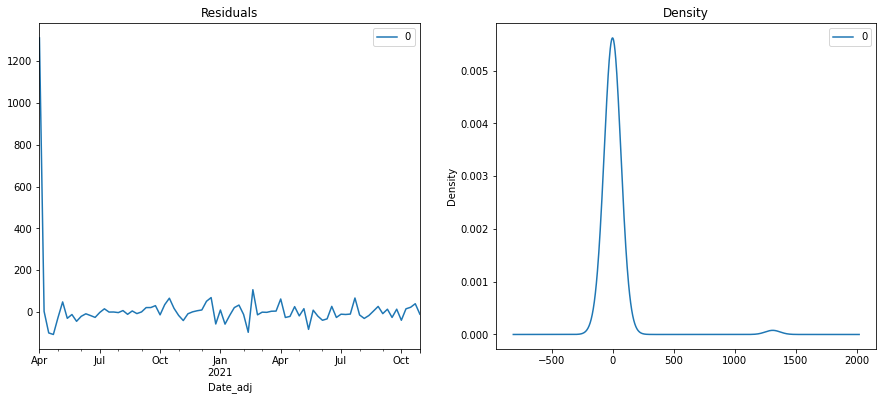

In [138]:
# Plot residual errors
residuals = pd.DataFrame(final_model.resid)
fig, ax = plt.subplots(1,2, figsize=(15,6))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Binnen de Density grafiek is een kleine bult te zijn tussen de 1000 en 1500, dit kan een mogelijk outlier zijn. In de volgende cel wordt een boxplot weergegeven van de waardes die zich binnen het dataframe Index_df_per_dag bevinden. Dankzij deze boxplot worden eventuele outliers in kaart gebracht.

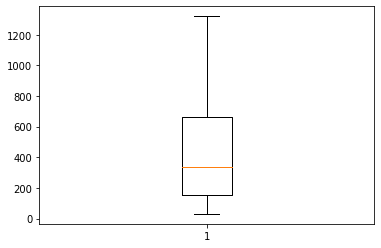

In [139]:
# Boxplot weergeven.
plt.boxplot(Index_df_per_dag)
plt.show()

Binnen het boxplot zijn geen outliers te zien. Hieruit kan geconcludeerd worden dat indien sprake is van een of meerdere outliers deze zo klein zijn dat ze waarschijnlijk het model niet beïnvloeden. 

# SARIMA
---
Binnen dit hoofdstuk wordt de benodigde IC-capaciteit voorspeld met behulp van een SARIMA-model.

In [140]:
model1 = sm.tsa.statespace.SARIMAX(Index_df_per_dag,
                                order=(2,1,3),
                                seasonal_order=(1, 0, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

model2 = sm.tsa.statespace.SARIMAX(Index_df_per_dag,
                                order=(2,1,1),
                                seasonal_order=(1, 0, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)                       

Nu de modellen zijn getraind worden de voorspellingen van de gerealiseerde modellen vergeleken met de IC-capaciteit van de periode 1 november 2021 tot en met 16 januari 2022. 

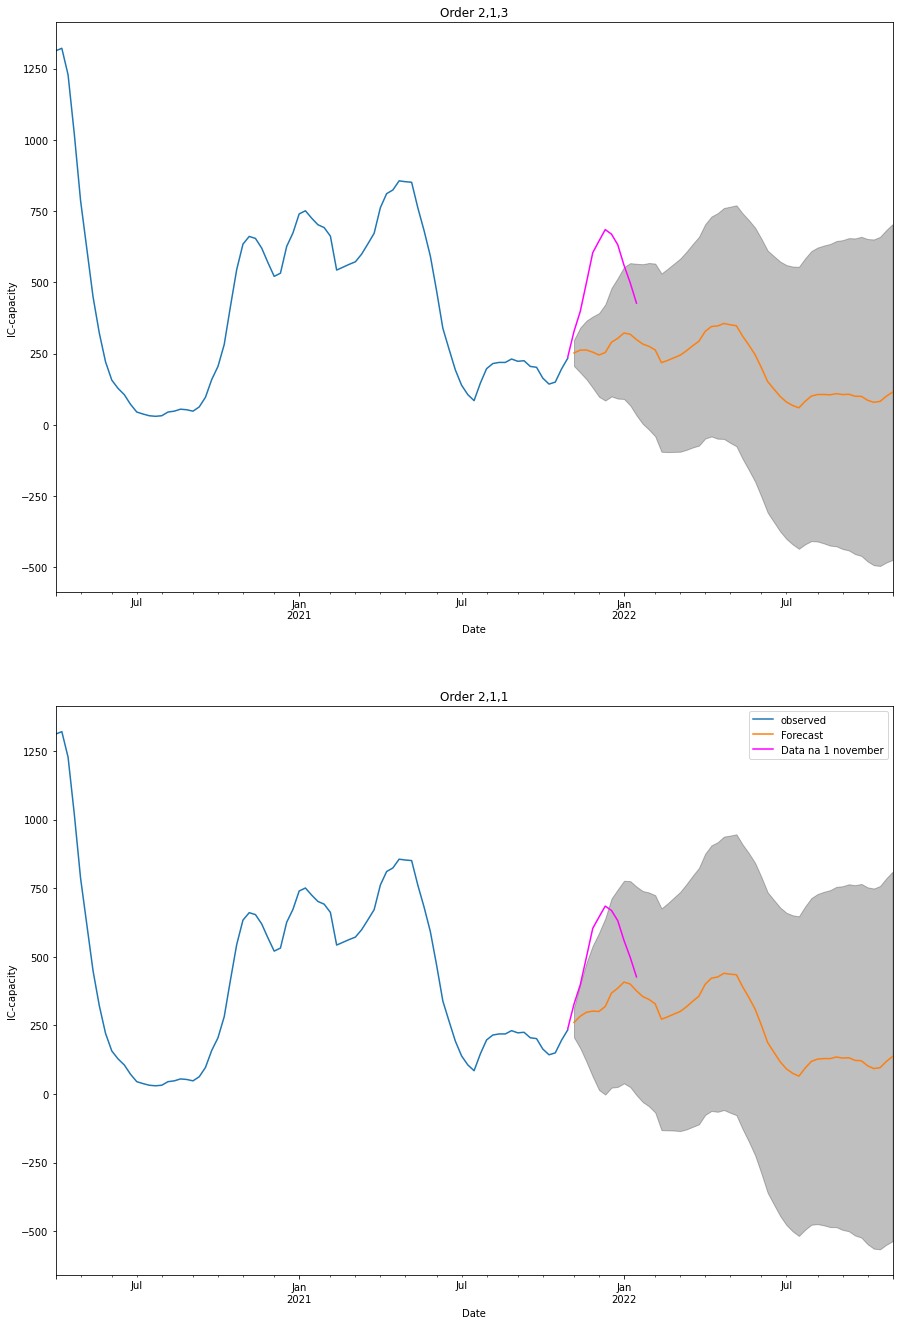

In [141]:
# Data preprocessing
df_per_dag_recent["Datum"] = pd.to_datetime(df_per_dag_recent["Datum"])
df_per_dag_recent = df_per_dag_recent.loc[(df_per_dag_recent["Datum"] >= "2020-04-01") & (df_per_dag_recent["Datum"] < "2022-01-16")]
Index_df_per_dag_recent = df_per_dag_recent[["Aanwezig op IC verdacht of bewezen Corona", "Datum"]]
Index_df_per_dag_recent.set_index(["Datum"], inplace=True)
Index_df_per_dag_recent = Index_df_per_dag_recent["Aanwezig op IC verdacht of bewezen Corona"].resample("W").max()

recent_data = Index_df_per_dag_recent[82:]

# Plot the results
plt.subplot(2,1,1)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=3, wspace=0.2, hspace=0.2)

#2,1,1
# Get forecast 52 steps ahead in future
results = model1.fit()
pred_uc = results.get_forecast(steps=52)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = Index_df_per_dag.plot(label='observed', figsize=(15,6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
recent_data.plot(label="Data na 1 november", color="magenta")
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_title("Order 2,1,3")
ax.set_xlabel('Date')
ax.set_ylabel('IC-capacity')
#ax.set_ylim(0,1500)

# 1,1,2
results2 = model2.fit()
# Get forecast 52 steps ahead in future
pred_uc = results2.get_forecast(steps=52)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

# Plot the results
plt.subplot(2,1,2)
ax = Index_df_per_dag.plot(label='observed', figsize=(15,6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
recent_data.plot(label="Data na 1 november", color="magenta")
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_title("Order 2,1,1")
ax.set_xlabel('Date')
ax.set_ylabel('IC-capacity')
#ax.set_ylim(0,1500)

plt.legend()
plt.show()


De grafieken in bovenstaande cel laten zien dat in beide modellen de magenta lijn aan het einde van november, begin december buiten het grijze gebied komt. Dit gebied is kleiner binnen de tweede grafiek met order 1,1,2 dan de eerste grafiek met order 2,1,1. Echter is het grijze gebied in de grafiek van het model met order 1,1,2 significant groter, waardoor de voorspellende lijn minder fluctueert dan bij de grafiek van het model met order 2,1,1. Vanwege de nauwkeurigere voorspelling (minder nauwkeurigheid) van het modellen met order 2,1,1 en lagere RMSE is het model de beste optie. Binnen de volgende cel wordt het model met order 2,1,1 nog een keer weergegeven.

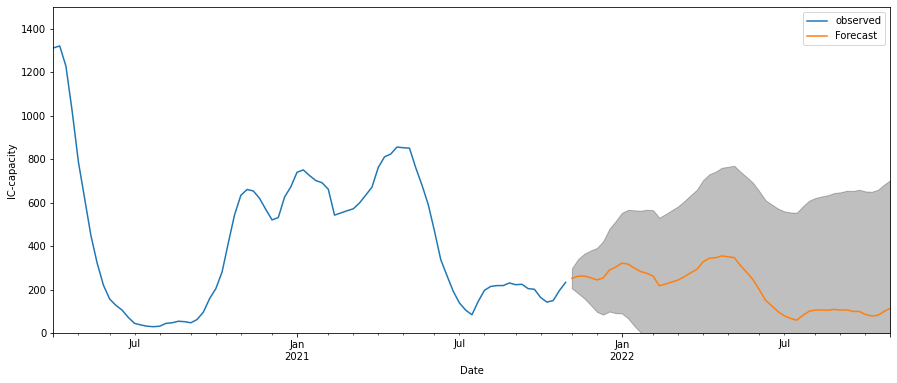

In [142]:
# Get forecast 52 steps ahead in future
pred_uc = results.get_forecast(steps=52)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = Index_df_per_dag.plot(label='observed', figsize=(15,6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('IC-capacity')
ax.set_ylim(0,1500)

plt.legend()
plt.show()

De IC-capaciteit die het SARIMA-model heeft voorspeld zijn te zien in bovenstaande grafiek (en eerdere gerealiseerde grafieken.). Naar aanleiding van de resultaten van het SARIMA-model blijkt de hypothese van [stats.stackexchange](https://stats.stackexchange.com/questions/286900/arima-forecast-straight-line) klopt. De voorspellingen hebben namelijk meer variatie zien. Daarnaast is de onzekerheid (het grijze gebied) aanzienlijk kleiner is dan het geval is bij het ARIMA-model. 